In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
from itertools import product

In [37]:
# Recompensas
REWARD_DATAGRAM = 0             # Existência de datagrama (no roteador ou em evento)
REWARD_DELETION = -1000         # Datagrama deletado devido a fila cheia
REWARD_COMPLETION = 50          # Datagrama recebido com sucesso no roteador final

# Ambiente

### Simulador de Redes

In [22]:
class Datagram:
    def __init__(self, source: int, destination: int):
        self.source = source
        self.destination = destination

In [23]:
class Queue:
    def __init__(self, size: int):
        self.queue = []
        self.size = size
        self.length = 0

    def is_empty(self):
        return self.length == 0
    
    def enqueue(self, datagram: Datagram):
        if self.length < self.size:
            self.queue.append(datagram)
            self.length += 1
            return True
        return False

    def dequeue(self):
        if not self.is_empty():
            self.length -= 1
            return self.queue.pop(0)
        return None

In [24]:
class Event:
    def __init__(self, delay: int, destination: int, datagram: Datagram):
        self.delay = delay
        self.destination = destination
        self.datagram = datagram

In [25]:
class Router:
    
    def __init__(self, address: int, size: int):
        self.address = address
        self.adjacents = {}
        self.size = size
        self.queue = Queue(self.size)
    
    def start(self, destinations):
        self.queue = Queue(self.size)
        for destination in destinations:
            if self.queue.enqueue(Datagram(-1, destination)) == False:
                raise Exception(f"start do roteador {self.address} excedeu capacidade máxima")

    def receive(self, datagram: Datagram):
        if datagram.destination != self.address:
            
            if self.queue.length == self.size:
                del datagram
                return REWARD_DELETION
            else:
                self.queue.enqueue(datagram)
                return 0
            
        else:
            del datagram
            return REWARD_COMPLETION

    def process(self, action: int): 
        if not self.queue.is_empty():
            datagram = self.queue.dequeue()
            if datagram.destination == self.address:
                del datagram
            else:
                return Event(self.adjacents[action][1], action, datagram)

In [26]:
def test_router():
    r0 = Router(0, 10)
    r1 = Router(1, 2)
    r0.start([1, 2, 1, 1])
    for d in r0.queue.queue:
        print(d.destination)

    print("----------------")

    print(f'reward = {r0.receive(Datagram(-1, 3))}')
    for d in r0.queue.queue:
        print(d.destination)

    print("----------------")

    print(f'reward = {r0.receive(Datagram(-1, 0))}')
    for d in r0.queue.queue:
        print(d.destination)

    print("----------------")

    r0.adjacents[4] = [r1, 8]
    event = r0.process(4)
    print(event.delay)
    print(event.destination)
    print(event.datagram.destination)

    print("----------------")

    for d in r0.queue.queue:
        print(d.destination)

    print("----------------")

    print(f'reward = {r1.receive(Datagram(-1, 0))}')
    print(f'reward = {r1.receive(Datagram(-1, 5))}')
    print(f'reward = {r1.receive(Datagram(-1, 7))}')
    for d in r1.queue.queue:
        print(d.destination)

In [27]:
class Network:
    def __init__(self, size: int, gen_prob: float, max_data: int, generate: bool=True) -> None:
        """
        @param size: size of the network
        @param gen_prob: probability of generating one packet
        @param max_data: max number of datagrams that can be generated in one instant
        """
        self.size = size
        self.quantity = 0
        self.routers = {}
        self.gen_prob = gen_prob
        self.max_data = max_data
        self.generate = generate

    def add_router(self, size):
        if self.quantity < self.size:
            self.quantity += 1
            self.routers[self.quantity] = Router(self.quantity, size)
            return True
        return False
    
    #método mapear
    def link(self, address_1, address_2, delay):
        """
        Ele deve ter o mesmo retorno do método mapear da TabelaDeRepasse: true se o
        mapeamento foi feito ou false caso o endereço já tenha um mapeamento ou a tabela esteja cheia.
        """
        if address_1 in self.routers and address_2 in self.routers:
            if address_1 not in self.routers[address_2].adjacents and address_2 not in self.routers[address_1].adjacents:
                self.routers[address_1].adjacents[address_2] = (self.routers[address_2], delay)
                self.routers[address_2].adjacents[address_1] = (self.routers[address_1], delay)
                return True
            else:
                return False
        else:
            return False
    
    def start(self, routers_state):
        for address in range(1, len(routers_state) + 1):
            self.routers[address].start(routers_state[address - 1])
    
    def generate_random_data(self):
        if self.generate:
            for _ in range(self.max_data):
                if np.random.random() < self.gen_prob:
                    sender = random.choice(list(self.routers.keys()))
                    # !!!!! Assumindo que a rede seja toda conectada !!!!! "
                    receiver = random.choice([address for address in list(self.routers.keys()) if address != sender])
                    # print((sender, receiver)) # não apagar: útil para testes
                    datagram = Datagram(sender, receiver)
                    self.routers[sender].receive(datagram)

In [28]:
def test_network():
    network = Network(10, 0.9, 3, True)
    network.add_router(10)
    network.add_router(3)
    network.add_router(6)
    for router in network.routers:
        print(router)
        print(network.routers[router].address)
        print(network.routers[router].size)
        print("-")

    print("----------------")

    print(network.link(1, 2, 8))
    print(network.link(1, 3, 40))
    print(network.link(1, 3, 60))

    for i in [1, 2, 3]:
        print(network.routers[i].adjacents)
        print([network.routers[i].adjacents[j][0].address for j in network.routers[i].adjacents])

    print("----------------")

    network.start([[2, 3, 2, 2], [], [2, 1, 1]])
    for router in network.routers.values():
        print("address:", router.address)
        for d in router.queue.queue:
            print(d.destination)
        print("-")

    print("----------------")

    network.generate_random_data()
    for router in network.routers.values():
        print("address:", router.address)
        for d in router.queue.queue:
            print(d.destination)
        print("-")

In [29]:
class Scheduler:
    def __init__(self, network: Network):
        self.network = network
        self.events = []
    
    def start(self, events):
        self.events = []
        for event in events:
            self.events.append(Event(event[0], event[1], Datagram(-1, event[2])))
    
    def process(self, action: list[int]):
        reward = 0
        for event in self.events:
            if event.delay == 0:
                reward += self.network.routers[event.destination].receive(event.datagram)
        self.events = [event for event in self.events if event.delay != 0]
        for event in self.events:
            event.delay -= 1
        for router in self.network.routers.values():            
            event = router.process(action[router.address - 1])
            if event is not None:
                self.events.append(event)
        self.network.generate_random_data()
        return reward

In [30]:
def test_scheduler():
    network = Network(10, 0.9, 3, True)
    network.add_router(10)
    network.add_router(3)
    network.add_router(6)
    network.link(1, 2, 8)
    network.link(1, 3, 40)
    network.link(1, 3, 60)
    network.start([[2, 3, 2, 2], [], [2, 1, 1]])
    scheduler = Scheduler(network)
    scheduler.start([[5, 1, 3], [8, 3, 1], [0, 2, 3]])
    for event in scheduler.events:
        print(event.delay, event.destination, event.datagram.destination)
    print("----------------")
    for router in network.routers.values():
        print(router.size, [datagram.destination for datagram in router.queue.queue])
    print("----------------")
    reward = scheduler.process([2, 1, 1])
    print(f'reward = {reward}')
    for event in scheduler.events:
        print(event.delay, event.destination, event.datagram.destination)
    for router in network.routers.values():
        print(router.size, [datagram.destination for datagram in router.queue.queue])
    print("----------------")
    reward = scheduler.process([3, 1, 1])
    print(f'reward = {reward}')
    for event in scheduler.events:
        print(event.delay, event.destination, event.datagram.destination)
    for router in network.routers.values():
        print(router.size, [datagram.destination for datagram in router.queue.queue])

### Interface do Ambiente

In [31]:
class Environment:
    def __init__(self, network: Network, scheduler: Scheduler):
        self.network = network
        self.scheduler = scheduler

    def get_all_states(self):
        def get_router_states(router):
            router_states = tuple(product(list(router.adjacents.keys()) + [0], repeat=router.size))
            def is_valid(x):
                for i in range(len(x)):
                    if x[i] == 0 and i < len(x) - 1:
                        return all([x[j] == 0 for j in range(i + 1, len(x))])
                return True
            router_states = filter(is_valid, router_states)
            router_states = [tuple(state) if 0 not in state else [] if state[0] == 0 else list(state[0:state.index(0)]) for state in router_states]
            return router_states
        aux = product(*[get_router_states(router) for router in self.network.routers.values()])
        routers_states = [tuple(routers_state) for routers_state in aux]

        min_delay = min([min([router.adjacents[address][1] for address in router.adjacents]) for router in self.network.routers.values()])
        events_states = product(range(min_delay + 1), self.network.routers.keys(), self.network.routers.keys())
        events_states = [tuple(event_state) for event_state in events_states]

        return product(events_states, routers_states)
    
    def get_state(self):
        events_state = []
        for event in self.scheduler.events:
            event_state = (event.delay, event.destination, event.datagram.destination)
            events_state.append(event_state)
        events_state = tuple(events_state)

        routers_state = []
        for router in self.network.routers.values():
            destinations = []
            for datagram in router.queue.queue:
                destinations.append(datagram.destination)
            routers_state.append(tuple(destinations))
        routers_state = tuple(routers_state)
            
        return (events_state, routers_state)
    
    def take_action(self, action):
        reward = 0
        for router in self.network.routers.values():
            reward += router.queue.length * REWARD_DATAGRAM
        reward += len(self.scheduler.events) * REWARD_DATAGRAM
        reward += self.scheduler.process(action)
        new_state = self.get_state()
        return reward, new_state
    
    def start(self, state = None): 
        if state == None:
            state = ([], [[] for i in self.network.routers])
        self.scheduler.start(state[0])
        self.network.start(state[1])
        
    def possible_actions(self, state = None):
        if state == None:
            state = self.get_state()
        action = {}
        for address in self.network.routers:
            if state[1][address - 1] == []:
                action[address] = [-1]
            else:
                action[address] = self.network.routers[address].adjacents
        return list(product(*action.values()))

In [35]:
def test_environment():
    network = Network(4, 1.0, 1)

    for _ in range(4):
        network.add_router(4)

    network.link(1, 2, 3)
    network.link(1, 3, 10)
    network.link(1, 4, 2)
    network.link(2, 4, 6)

    scheduler = Scheduler(network)

    env = Environment(network, scheduler)

    print(len(list(env.get_all_states())))
    print()

    print(env.get_state())
    print()

    env.start()
    print(env.get_state())
    print(env.possible_actions())
    print()

    env.start((((4, 1, 2), (1, 2, 4)), ((2, 4, 3), (4,), (1, 2, 1, 1), tuple())))
    print(env.get_state())
    print(env.possible_actions())
    print()

    reward, new_state = env.take_action((3, 4, 1, -1))
    print(reward)
    print(new_state)
    print(new_state ==env.get_state())
    print(env.possible_actions())

**OBS: tudo no estado deve ser TUPLA**
<br>
estado atualmente eh um par ordenado com:
- 1 elemento: tupla de estados dos eventos, onde cada estado eh (delay, destino imediato, destino final)
- 2 elemento: tupla de estados dos roteadores, onde cada estado corresponde a um roteador (via endereço) e eh uma tupla dos destinos dos datagramas (na ordem da fila)

![rede 1](./img/rede1.png)

# Agentes

### Q-Learning

In [39]:
class Agent_Q_Learning:
    def __init__(self, env):
        self.env = env
        self.policy = {}
        self.values = {}

    def q_learning(self, alpha, epsilon, time_steps, gama):
        self.initialize() #Initialize value table 

        self.env.start()
        
        for t in range(time_steps):
            state = self.env.get_state()
            
            if random.random() >= epsilon:
                action = max(self.values[state], key = self.values[state].get)
            else:
                action = random.choice(list(self.values[state].keys())) #ou usar o possible actions

            reward, next_state = self.env.take_action(action)
            self.values[state][action] += alpha*(reward + gama*max(self.values[next_state].values()) - self.values[state][action])
        
    def initialize(self):
        ...

### SARSA

In [40]:
class StateActionArray:
    def __init__(self, env: Environment):
        ...
    def get(self, state, action):
        ...
    def set(self, state, action, value):
        ...

class Policy:
    def __init__(self, env:Environment, eps: float=0):
        ...
    def get(self, state):
        ...
    def set(self, state, action):
        ...
        
def sarsa(env: Environment, returns: StateActionArray, policy: Policy, gamma: float, alpha: float):
    
    env.reset()
    state = env.get_state()
    action = policy.get(state)
    while True:
        reward, next_state = env.take_action(action)
        next_action = policy.get(next_state)
        current_return = returns.get(state, action)
        
        next_return = 0
        if not env.terminal():
            next_return = returns.get(next_state, next_action)

        new_return = current_return + alpha * (gamma * next_return - current_return + reward)
        returns.set(state, action, new_return)

        actions = env.possible_actions()
        values = [returns.get(state, act) for act in actions]
        policy.set(state, actions[np.argmax(values)])

        state = next_state
        action = next_action
        if env.terminal():
            break

### Monte Carlo

In [48]:
class Episode:
    def __init__(self, env : Environment, agent, initial_state, initial_action):
        self.env = env
        self.initial_state = initial_state
        self.initial_action = initial_action
        self.pairs = []
        self.rewards = []
        self.agent = agent
        self.steps = 0

    def genEpisode(self):
        self.env.start(self.initial_state)
        state = self.initial_state
        action = self.initial_action
        while True:
            self.pairs.append((state, action))
            reward, state = self.env.take_action(action)
            self.rewards.append(reward)
            self.steps += 1
            if state == -1 or self.steps == 50:
                self.steps = len(self.rewards)
                return
            action = self.agent.choose_action(state)


In [54]:
class Agent_MC:
    def __init__(self, env: Environment, strategy, eps=None):
        self.env = env
        self.hashmap = dict()
        if strategy == 'ExpStarts':
            for state in env.get_all_states():
                self.hashmap[state] = env.possible_actions(state)
        self.Q_values = {(state, action) : [0, 0] for state in self.hashmap for action in self.hashmap[state]}
        self.policy = {state : random.choice(self.hashmap[state]) for state in self.hashmap}
        self.strategy = strategy
        self.eps=eps

    def initialize(self):
        for state in self.hashmap:
            for action in self.hashmap[state]:
                self.Q_values[(state, action)] = [0, 0]
            self.policy[state] = random.choice(self.hashmap[state])
    
    def choose_action(self, state):
        if state not in self.hashmap.keys():
            self.hashmap[state] = self.env.possible_actions(state)
            for action in self.hashmap[state]:
                self.Q_values[(state, action)] = [0, 0]
            self.policy[state] = random.choice(self.hashmap[state])
        
        if self.strategy == 'ExpStarts':
            return self.policy[state]
        else: # implementação com eps greedy
            if random.random() < self.eps:
                return random.choice(self.env.possible_actions(state))
            else:
                return self.policy[state]
    
    def learn(self, numEpisodes, gamma, first_visit=True, restart_state=False):
        global last_episode
        global returns
        global hashmap
        hashmap = self.hashmap
        global qvalues
        qvalues = self.Q_values

        returns = []
        initial_state = self.env.get_state()

        for _ in range(1, numEpisodes + 1):
            print(_)
            last_episode = _
            
            if self.strategy == "ExpStarts":
                initial_state = random.choice(self.hashmap)
                initial_action = random.choice(self.hashmap[initial_state])
            else:
                if not restart_state:
                    initial_state = self.env.get_state()
                initial_action = self.choose_action(initial_state)
            
            episode = Episode(self.env, self, initial_state, initial_action)
            episode.genEpisode()

            G = 0
            for step in range(episode.steps - 1, -1, -1):
                G = gamma * G + episode.rewards[step]
                pair = episode.pairs[step]
                if not first_visit or pair not in episode.pairs[0:step]:
                    self.Q_values[pair][0] = (self.Q_values[pair][0] * self.Q_values[pair][1] + G) / (self.Q_values[pair][1] + 1)
                    self.Q_values[pair][1] += 1
                    self.policy[pair[0]] = self.hashmap[pair[0]][np.argmax([self.Q_values[(pair[0], action)][0] for action in self.hashmap[pair[0]]])]
            returns.append(G)
        
        return


In [55]:
network = Network(size=10, gen_prob=0.5, max_data=2, generate=True)
for i in range(4):
    network.add_router(8)
network.link(1, 2, 5)
network.link(1, 3, 2)
network.link(2, 4, 3)
network.link(3, 4, 4)

scheduler = Scheduler(network)

env = Environment(network, scheduler)
env.start(([], [[4, 3, 2, 4, 2, 2], [1, 3, 1, 4, 4], [2, 2, 4, 1], [1]]))

agent_eps = Agent_MC(env=env, strategy='EpsSoft', eps=0.1)

agent_eps.learn(numEpisodes=10000, gamma=0.9)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [56]:
print(last_episode)
print(len(hashmap))
print(len(qvalues))
freqs = [freq for state in hashmap for action in hashmap[state] if (freq := qvalues[(state, action)][1]) != 0]
freqs.sort(reverse=True)
print(len(freqs))
print(freqs[0:5])

10000
500000
8000000
500000
[1, 1, 1, 1, 1]


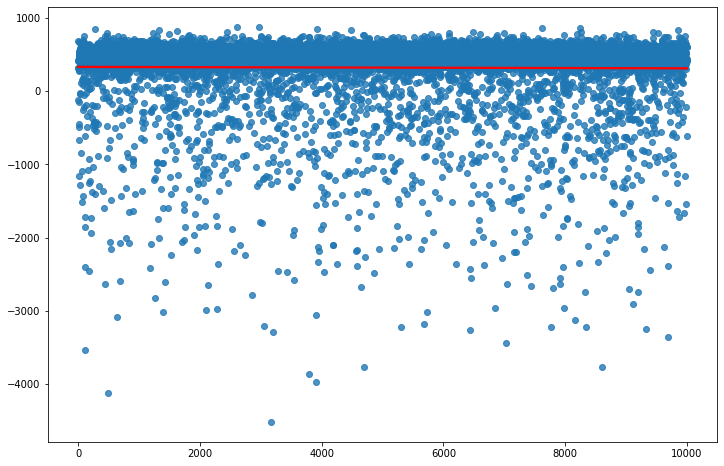

In [57]:
plt.figure(figsize=(12, 8))
sns.regplot(x=list(range(last_episode)), y=returns, line_kws={'color' : 'red'})
plt.show()

In [59]:
env.get_state()

(((0, 2, 3),
  (1, 2, 3),
  (1, 1, 3),
  (1, 4, 2),
  (0, 2, 2),
  (0, 3, 3),
  (0, 1, 4),
  (2, 3, 1),
  (4, 2, 4),
  (4, 1, 3),
  (2, 2, 2),
  (2, 3, 2),
  (5, 1, 4),
  (2, 1, 2),
  (3, 2, 1)),
 ((3, 4, 2, 4, 4), (), (1,), ()))